In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/porcelain')
mask_dir = os.path.join(dataset_dir,'mask/porcelain')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/porcelain C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/porcelain
15759
15759


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-16 20:04:43,917: INFO: 3804955329: date_time: 20250216-200443]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "pspnet",
    "backbone" : "resnet50", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-16 20:04:44,063: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-16 20:04:44,063: INFO: 342151172: model_config: {'model_name': 'pspnet', 'backbone': 'resnet50', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-16 20:04:44,064: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-16 20:04:44,064: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

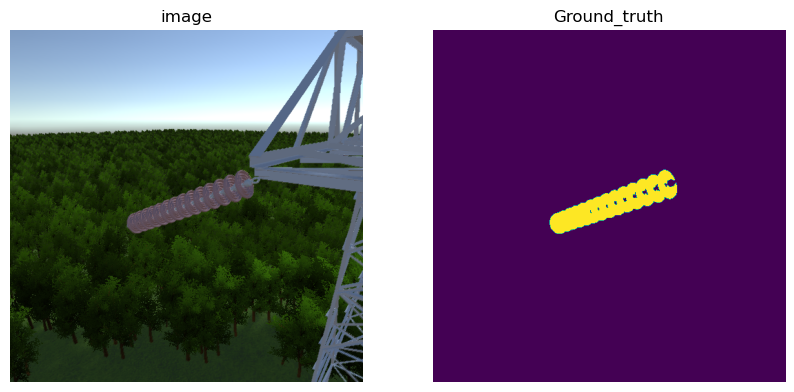

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-16 20:04:44,422: INFO: 3993860970: data injection started]
[2025-02-16 20:04:44,425: INFO: 3993860970: train data spliting ]
[2025-02-16 20:04:44,427: INFO: 3993860970: val test spliting ]
[2025-02-16 20:04:44,428: INFO: 3993860970: csv saving started]
[2025-02-16 20:04:44,447: INFO: 3993860970: train csv done ]
[2025-02-16 20:04:44,451: INFO: 3993860970: val csv done ]
[2025-02-16 20:04:44,455: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [04:23<00:00,  7.99it/s, epoch=0, train_loss=0.0405, train_Miou_score=0.19, train_dice_score=0.437, train_acc=0.965, train_binary_jaccard_index=0.508, train_dice_coefficient=0.64]        

[2025-02-16 20:09:57,282: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.04051628065154623]
[2025-02-16 20:09:57,283: INFO: 2273413975: train_loss 0.049327332034886144]
[2025-02-16 20:09:57,283: INFO: 2273413975: train_Miou_score 0.18955030003436002]
[2025-02-16 20:09:57,284: INFO: 2273413975: train_dice_score 0.43689649740945996]
[2025-02-16 20:09:57,284: INFO: 2273413975: train_acc 0.964777677272979]
[2025-02-16 20:09:57,284: INFO: 2273413975: train_binary_jaccard_index: 0.5075922424072423]
[2025-02-16 20:09:57,285: INFO: 2273413975: train_dice_coefficient: 0.6395859974862437]



100%|██████████| 788/788 [00:26<00:00, 29.44it/s, epoch=0, eval_loss=0.0211, eval_Miou_score=0.283, eval_dice_score=0.617, eval_acc=0.979, eval_binary_jaccard_index=0.726, eval_dice_coefficient=0.825]

[2025-02-16 20:10:24,059: INFO: 2273413975: Epoch: 0 | Loss: 0.021100353090291096]
[2025-02-16 20:10:24,059: INFO: 2273413975: eval_loss 0.021666040017287995]
[2025-02-16 20:10:24,059: INFO: 2273413975: eval_Miou_score 0.2827703882355082]
[2025-02-16 20:10:24,060: INFO: 2273413975: eval_dice_score 0.6168154670105217]
[2025-02-16 20:10:24,060: INFO: 2273413975: eval_acc 0.9791285035573891]
[2025-02-16 20:10:24,060: INFO: 2273413975: eval_binary_jaccard_index: 0.726190193667346]
[2025-02-16 20:10:24,061: INFO: 2273413975: eval_dice_coefficient: 0.824761381005581]



100%|██████████| 2102/2102 [04:14<00:00,  8.25it/s, epoch=1, train_loss=0.0145, train_Miou_score=0.256, train_dice_score=0.553, train_acc=0.975, train_binary_jaccard_index=0.662, train_dice_coefficient=0.767]

[2025-02-16 20:14:38,880: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.014490167687440577]
[2025-02-16 20:14:38,880: INFO: 2273413975: train_loss 0.03333571939110704]
[2025-02-16 20:14:38,880: INFO: 2273413975: train_Miou_score 0.25567343662895753]
[2025-02-16 20:14:38,881: INFO: 2273413975: train_dice_score 0.5525314543165197]
[2025-02-16 20:14:38,881: INFO: 2273413975: train_acc 0.9752527556951901]
[2025-02-16 20:14:38,881: INFO: 2273413975: train_binary_jaccard_index: 0.6617350368584821]
[2025-02-16 20:14:38,882: INFO: 2273413975: train_dice_coefficient: 0.7667282501061771]



100%|██████████| 788/788 [00:25<00:00, 30.87it/s, epoch=1, eval_loss=0.0123, eval_Miou_score=0.303, eval_dice_score=0.648, eval_acc=0.983, eval_binary_jaccard_index=0.776, eval_dice_coefficient=0.861]

[2025-02-16 20:15:04,414: INFO: 2273413975: Epoch: 1 | Loss: 0.012348548107340856]
[2025-02-16 20:15:04,414: INFO: 2273413975: eval_loss 0.017016972133876748]
[2025-02-16 20:15:04,414: INFO: 2273413975: eval_Miou_score 0.3026670886509163]
[2025-02-16 20:15:04,415: INFO: 2273413975: eval_dice_score 0.6475072955466845]
[2025-02-16 20:15:04,415: INFO: 2273413975: eval_acc 0.9834661798428763]
[2025-02-16 20:15:04,415: INFO: 2273413975: eval_binary_jaccard_index: 0.7755862195671153]
[2025-02-16 20:15:04,415: INFO: 2273413975: eval_dice_coefficient: 0.8613540916075526]



100%|██████████| 2102/2102 [04:15<00:00,  8.23it/s, epoch=2, train_loss=0.0113, train_Miou_score=0.281, train_dice_score=0.6, train_acc=0.98, train_binary_jaccard_index=0.724, train_dice_coefficient=0.816]   

[2025-02-16 20:19:19,750: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.01128561036230608]
[2025-02-16 20:19:19,751: INFO: 2273413975: train_loss 0.025973958521556796]
[2025-02-16 20:19:19,751: INFO: 2273413975: train_Miou_score 0.28101883208481104]
[2025-02-16 20:19:19,752: INFO: 2273413975: train_dice_score 0.6003873136400975]
[2025-02-16 20:19:19,752: INFO: 2273413975: train_acc 0.9797740312528882]
[2025-02-16 20:19:19,753: INFO: 2273413975: train_binary_jaccard_index: 0.7243309010720954]
[2025-02-16 20:19:19,753: INFO: 2273413975: train_dice_coefficient: 0.8164584757885456]



100%|██████████| 788/788 [00:25<00:00, 30.38it/s, epoch=2, eval_loss=0.019, eval_Miou_score=0.308, eval_dice_score=0.657, eval_acc=0.983, eval_binary_jaccard_index=0.783, eval_dice_coefficient=0.865] 

[2025-02-16 20:19:45,692: INFO: 2273413975: Epoch: 2 | Loss: 0.018969110955441664]
[2025-02-16 20:19:45,692: INFO: 2273413975: eval_loss 0.01817342816298914]
[2025-02-16 20:19:45,692: INFO: 2273413975: eval_Miou_score 0.30845568528459544]
[2025-02-16 20:19:45,693: INFO: 2273413975: eval_dice_score 0.6574816998478826]
[2025-02-16 20:19:45,693: INFO: 2273413975: eval_acc 0.982699262712611]
[2025-02-16 20:19:45,693: INFO: 2273413975: eval_binary_jaccard_index: 0.7825317507831919]
[2025-02-16 20:19:45,694: INFO: 2273413975: eval_dice_coefficient: 0.8650689472228953]



100%|██████████| 2102/2102 [04:15<00:00,  8.24it/s, epoch=3, train_loss=0.0113, train_Miou_score=0.293, train_dice_score=0.625, train_acc=0.982, train_binary_jaccard_index=0.756, train_dice_coefficient=0.841]

[2025-02-16 20:24:00,838: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.011295401006511685]
[2025-02-16 20:24:00,839: INFO: 2273413975: train_loss 0.022495679756307577]
[2025-02-16 20:24:00,840: INFO: 2273413975: train_Miou_score 0.2934332500220915]
[2025-02-16 20:24:00,840: INFO: 2273413975: train_dice_score 0.6246662614457377]
[2025-02-16 20:24:00,840: INFO: 2273413975: train_acc 0.9820231934787828]
[2025-02-16 20:24:00,841: INFO: 2273413975: train_binary_jaccard_index: 0.755548633835607]
[2025-02-16 20:24:00,841: INFO: 2273413975: train_dice_coefficient: 0.8412455861505576]



100%|██████████| 788/788 [00:26<00:00, 29.84it/s, epoch=3, eval_loss=0.00986, eval_Miou_score=0.314, eval_dice_score=0.672, eval_acc=0.985, eval_binary_jaccard_index=0.801, eval_dice_coefficient=0.879]

[2025-02-16 20:24:27,252: INFO: 2273413975: Epoch: 3 | Loss: 0.009863349235602442]
[2025-02-16 20:24:27,252: INFO: 2273413975: eval_loss 0.016197724303789757]
[2025-02-16 20:24:27,253: INFO: 2273413975: eval_Miou_score 0.3142819980640723]
[2025-02-16 20:24:27,253: INFO: 2273413975: eval_dice_score 0.6718263691243938]
[2025-02-16 20:24:27,253: INFO: 2273413975: eval_acc 0.9845739258122324]
[2025-02-16 20:24:27,254: INFO: 2273413975: eval_binary_jaccard_index: 0.8009598453116702]
[2025-02-16 20:24:27,254: INFO: 2273413975: eval_dice_coefficient: 0.8785238091462128]



100%|██████████| 2102/2102 [04:15<00:00,  8.23it/s, epoch=4, train_loss=0.00997, train_Miou_score=0.302, train_dice_score=0.642, train_acc=0.984, train_binary_jaccard_index=0.777, train_dice_coefficient=0.858]

[2025-02-16 20:28:42,557: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.009968164815548824]
[2025-02-16 20:28:42,557: INFO: 2273413975: train_loss 0.020222412828624855]
[2025-02-16 20:28:42,558: INFO: 2273413975: train_Miou_score 0.3021869159484326]
[2025-02-16 20:28:42,558: INFO: 2273413975: train_dice_score 0.6423896974310744]
[2025-02-16 20:28:42,559: INFO: 2273413975: train_acc 0.9836351260557048]
[2025-02-16 20:28:42,559: INFO: 2273413975: train_binary_jaccard_index: 0.7770131369514537]
[2025-02-16 20:28:42,559: INFO: 2273413975: train_dice_coefficient: 0.857847560699199]



100%|██████████| 788/788 [00:26<00:00, 29.86it/s, epoch=4, eval_loss=0.00991, eval_Miou_score=0.318, eval_dice_score=0.684, eval_acc=0.986, eval_binary_jaccard_index=0.813, eval_dice_coefficient=0.887]

[2025-02-16 20:29:08,949: INFO: 2273413975: Epoch: 4 | Loss: 0.00990906297252868]
[2025-02-16 20:29:08,950: INFO: 2273413975: eval_loss 0.014826173671265238]
[2025-02-16 20:29:08,950: INFO: 2273413975: eval_Miou_score 0.31815824585075625]


[2025-02-16 20:29:08,951: INFO: 2273413975: eval_dice_score 0.6840346584540938]
[2025-02-16 20:29:08,951: INFO: 2273413975: eval_acc 0.9856875347001903]
[2025-02-16 20:29:08,951: INFO: 2273413975: eval_binary_jaccard_index: 0.8126572839816474]
[2025-02-16 20:29:08,952: INFO: 2273413975: eval_dice_coefficient: 0.8867811719943539]


100%|██████████| 2102/2102 [04:16<00:00,  8.21it/s, epoch=5, train_loss=0.00967, train_Miou_score=0.308, train_dice_score=0.656, train_acc=0.985, train_binary_jaccard_index=0.792, train_dice_coefficient=0.87] 

[2025-02-16 20:33:25,038: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.009670969137796099]
[2025-02-16 20:33:25,038: INFO: 2273413975: train_loss 0.01851330447812801]
[2025-02-16 20:33:25,039: INFO: 2273413975: train_Miou_score 0.30827602874252397]
[2025-02-16 20:33:25,039: INFO: 2273413975: train_dice_score 0.655657033455651]
[2025-02-16 20:33:25,040: INFO: 2273413975: train_acc 0.9847599040188753]
[2025-02-16 20:33:25,040: INFO: 2273413975: train_binary_jaccard_index: 0.7922624795697546]
[2025-02-16 20:33:25,040: INFO: 2273413975: train_dice_coefficient: 0.8695031922445638]



100%|██████████| 788/788 [00:26<00:00, 30.20it/s, epoch=5, eval_loss=0.00834, eval_Miou_score=0.323, eval_dice_score=0.695, eval_acc=0.987, eval_binary_jaccard_index=0.823, eval_dice_coefficient=0.894]

[2025-02-16 20:33:51,139: INFO: 2273413975: Epoch: 5 | Loss: 0.008336714908556284]
[2025-02-16 20:33:51,139: INFO: 2273413975: eval_loss 0.013843036420610843]
[2025-02-16 20:33:51,140: INFO: 2273413975: eval_Miou_score 0.3230257666530521]
[2025-02-16 20:33:51,140: INFO: 2273413975: eval_dice_score 0.694502362738759]
[2025-02-16 20:33:51,140: INFO: 2273413975: eval_acc 0.9866952863844921]
[2025-02-16 20:33:51,140: INFO: 2273413975: eval_binary_jaccard_index: 0.8225803659726942]
[2025-02-16 20:33:51,141: INFO: 2273413975: eval_dice_coefficient: 0.8935467977980501]



100%|██████████| 2102/2102 [04:16<00:00,  8.19it/s, epoch=6, train_loss=0.00776, train_Miou_score=0.314, train_dice_score=0.667, train_acc=0.986, train_binary_jaccard_index=0.806, train_dice_coefficient=0.88] 

[2025-02-16 20:38:07,674: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.007761136732364586]
[2025-02-16 20:38:07,675: INFO: 2273413975: train_loss 0.01701374497098537]
[2025-02-16 20:38:07,675: INFO: 2273413975: train_Miou_score 0.314029975559491]
[2025-02-16 20:38:07,675: INFO: 2273413975: train_dice_score 0.6673533461533077]
[2025-02-16 20:38:07,676: INFO: 2273413975: train_acc 0.9858383627220294]
[2025-02-16 20:38:07,676: INFO: 2273413975: train_binary_jaccard_index: 0.8063032713239244]
[2025-02-16 20:38:07,677: INFO: 2273413975: train_dice_coefficient: 0.8796606258294999]



100%|██████████| 788/788 [00:26<00:00, 30.02it/s, epoch=6, eval_loss=0.012, eval_Miou_score=0.324, eval_dice_score=0.697, eval_acc=0.987, eval_binary_jaccard_index=0.825, eval_dice_coefficient=0.894] 

[2025-02-16 20:38:33,927: INFO: 2273413975: Epoch: 6 | Loss: 0.012040796391855036]
[2025-02-16 20:38:33,927: INFO: 2273413975: eval_loss 0.013730553073196018]
[2025-02-16 20:38:33,927: INFO: 2273413975: eval_Miou_score 0.324370027939246]
[2025-02-16 20:38:33,928: INFO: 2273413975: eval_dice_score 0.6974961254090621]
[2025-02-16 20:38:33,929: INFO: 2273413975: eval_acc 0.9868875773943707]
[2025-02-16 20:38:33,929: INFO: 2273413975: eval_binary_jaccard_index: 0.824737901174672]
[2025-02-16 20:38:33,929: INFO: 2273413975: eval_dice_coefficient: 0.8942870589988062]



100%|██████████| 2102/2102 [04:15<00:00,  8.22it/s, epoch=7, train_loss=0.00714, train_Miou_score=0.319, train_dice_score=0.678, train_acc=0.987, train_binary_jaccard_index=0.818, train_dice_coefficient=0.888]

[2025-02-16 20:42:49,651: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.007141423043923419]
[2025-02-16 20:42:49,652: INFO: 2273413975: train_loss 0.01584781120955967]
[2025-02-16 20:42:49,652: INFO: 2273413975: train_Miou_score 0.3188758982929944]
[2025-02-16 20:42:49,653: INFO: 2273413975: train_dice_score 0.6780218029660424]
[2025-02-16 20:42:49,653: INFO: 2273413975: train_acc 0.9867255216771001]
[2025-02-16 20:42:49,654: INFO: 2273413975: train_binary_jaccard_index: 0.8179864611657146]
[2025-02-16 20:42:49,654: INFO: 2273413975: train_dice_coefficient: 0.8879181493301254]



100%|██████████| 788/788 [00:26<00:00, 29.65it/s, epoch=7, eval_loss=0.00784, eval_Miou_score=0.327, eval_dice_score=0.705, eval_acc=0.988, eval_binary_jaccard_index=0.832, eval_dice_coefficient=0.899]

[2025-02-16 20:43:16,236: INFO: 2273413975: Epoch: 7 | Loss: 0.007841444787035134]
[2025-02-16 20:43:16,237: INFO: 2273413975: eval_loss 0.012924378281595601]
[2025-02-16 20:43:16,237: INFO: 2273413975: eval_Miou_score 0.3271814914619542]
[2025-02-16 20:43:16,237: INFO: 2273413975: eval_dice_score 0.705077002712568]
[2025-02-16 20:43:16,238: INFO: 2273413975: eval_acc 0.9875578105752238]
[2025-02-16 20:43:16,238: INFO: 2273413975: eval_binary_jaccard_index: 0.8318706926071856]
[2025-02-16 20:43:16,238: INFO: 2273413975: eval_dice_coefficient: 0.8990214095136714]



100%|██████████| 2102/2102 [04:16<00:00,  8.19it/s, epoch=8, train_loss=0.00664, train_Miou_score=0.323, train_dice_score=0.688, train_acc=0.987, train_binary_jaccard_index=0.828, train_dice_coefficient=0.895]

[2025-02-16 20:47:32,938: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.006638603591555986]
[2025-02-16 20:47:32,939: INFO: 2273413975: train_loss 0.014873347406351125]
[2025-02-16 20:47:32,939: INFO: 2273413975: train_Miou_score 0.32321484840505954]
[2025-02-16 20:47:32,940: INFO: 2273413975: train_dice_score 0.6883164952704206]
[2025-02-16 20:47:32,940: INFO: 2273413975: train_acc 0.9874716969656886]
[2025-02-16 20:47:32,941: INFO: 2273413975: train_binary_jaccard_index: 0.8279471494859766]
[2025-02-16 20:47:32,941: INFO: 2273413975: train_dice_coefficient: 0.8948228957563163]



100%|██████████| 788/788 [00:26<00:00, 29.68it/s, epoch=8, eval_loss=0.00562, eval_Miou_score=0.331, eval_dice_score=0.715, eval_acc=0.988, eval_binary_jaccard_index=0.841, eval_dice_coefficient=0.905]

[2025-02-16 20:47:59,497: INFO: 2273413975: Epoch: 8 | Loss: 0.005618587438830264]
[2025-02-16 20:47:59,497: INFO: 2273413975: eval_loss 0.012079687624893169]
[2025-02-16 20:47:59,497: INFO: 2273413975: eval_Miou_score 0.33079962216448183]
[2025-02-16 20:47:59,498: INFO: 2273413975: eval_dice_score 0.7148462666773269]
[2025-02-16 20:47:59,498: INFO: 2273413975: eval_acc 0.9883262819310601]
[2025-02-16 20:47:59,499: INFO: 2273413975: eval_binary_jaccard_index: 0.8405920936506992]
[2025-02-16 20:47:59,499: INFO: 2273413975: eval_dice_coefficient: 0.9047361469192284]



100%|██████████| 2102/2102 [04:17<00:00,  8.16it/s, epoch=9, train_loss=0.00635, train_Miou_score=0.327, train_dice_score=0.697, train_acc=0.988, train_binary_jaccard_index=0.836, train_dice_coefficient=0.901]

[2025-02-16 20:52:17,176: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.006347401016219018]
[2025-02-16 20:52:17,176: INFO: 2273413975: train_loss 0.01399055893730491]
[2025-02-16 20:52:17,177: INFO: 2273413975: train_Miou_score 0.32667835761259256]
[2025-02-16 20:52:17,177: INFO: 2273413975: train_dice_score 0.697255251376844]
[2025-02-16 20:52:17,178: INFO: 2273413975: train_acc 0.9880971136757241]
[2025-02-16 20:52:17,178: INFO: 2273413975: train_binary_jaccard_index: 0.8362289413598296]
[2025-02-16 20:52:17,178: INFO: 2273413975: train_dice_coefficient: 0.9005295235467927]



100%|██████████| 788/788 [00:26<00:00, 29.55it/s, epoch=9, eval_loss=0.0072, eval_Miou_score=0.333, eval_dice_score=0.72, eval_acc=0.989, eval_binary_jaccard_index=0.845, eval_dice_coefficient=0.908]  

[2025-02-16 20:52:43,851: INFO: 2273413975: Epoch: 9 | Loss: 0.007197232491473861]
[2025-02-16 20:52:43,851: INFO: 2273413975: eval_loss 0.011620323837794858]
[2025-02-16 20:52:43,852: INFO: 2273413975: eval_Miou_score 0.332937253068076]
[2025-02-16 20:52:43,852: INFO: 2273413975: eval_dice_score 0.7196492259007723]
[2025-02-16 20:52:43,853: INFO: 2273413975: eval_acc 0.9887801516479647]
[2025-02-16 20:52:43,853: INFO: 2273413975: eval_binary_jaccard_index: 0.8449379680843712]
[2025-02-16 20:52:43,853: INFO: 2273413975: eval_dice_coefficient: 0.9076937628571928]



100%|██████████| 2102/2102 [04:19<00:00,  8.10it/s, epoch=10, train_loss=0.00586, train_Miou_score=0.33, train_dice_score=0.705, train_acc=0.989, train_binary_jaccard_index=0.843, train_dice_coefficient=0.905] 

[2025-02-16 20:57:03,206: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.005862127730780619]
[2025-02-16 20:57:03,207: INFO: 2273413975: train_loss 0.01323007833551583]
[2025-02-16 20:57:03,208: INFO: 2273413975: train_Miou_score 0.32966188235079597]
[2025-02-16 20:57:03,208: INFO: 2273413975: train_dice_score 0.704659394448375]
[2025-02-16 20:57:03,209: INFO: 2273413975: train_acc 0.9886526253763012]
[2025-02-16 20:57:03,209: INFO: 2273413975: train_binary_jaccard_index: 0.8433793245040621]
[2025-02-16 20:57:03,210: INFO: 2273413975: train_dice_coefficient: 0.9054297845341749]



100%|██████████| 788/788 [00:26<00:00, 29.57it/s, epoch=10, eval_loss=0.00791, eval_Miou_score=0.334, eval_dice_score=0.723, eval_acc=0.989, eval_binary_jaccard_index=0.848, eval_dice_coefficient=0.91] 

[2025-02-16 20:57:29,860: INFO: 2273413975: Epoch: 10 | Loss: 0.00791274525489904]
[2025-02-16 20:57:29,860: INFO: 2273413975: eval_loss 0.011271501058365097]
[2025-02-16 20:57:29,861: INFO: 2273413975: eval_Miou_score 0.33413625268694735]
[2025-02-16 20:57:29,861: INFO: 2273413975: eval_dice_score 0.7232464573156547]
[2025-02-16 20:57:29,862: INFO: 2273413975: eval_acc 0.9890867925537419]
[2025-02-16 20:57:29,862: INFO: 2273413975: eval_binary_jaccard_index: 0.8483301820448351]
[2025-02-16 20:57:29,863: INFO: 2273413975: eval_dice_coefficient: 0.9098799199437729]



100%|██████████| 2102/2102 [04:17<00:00,  8.15it/s, epoch=11, train_loss=0.006, train_Miou_score=0.332, train_dice_score=0.711, train_acc=0.989, train_binary_jaccard_index=0.849, train_dice_coefficient=0.909]  

[2025-02-16 21:01:47,643: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.006003268750705229]
[2025-02-16 21:01:47,643: INFO: 2273413975: train_loss 0.012665408669086616]
[2025-02-16 21:01:47,644: INFO: 2273413975: train_Miou_score 0.33217924050405406]
[2025-02-16 21:01:47,644: INFO: 2273413975: train_dice_score 0.7108178591565292]
[2025-02-16 21:01:47,644: INFO: 2273413975: train_acc 0.9891031116277896]
[2025-02-16 21:01:47,645: INFO: 2273413975: train_binary_jaccard_index: 0.8492562030264349]
[2025-02-16 21:01:47,645: INFO: 2273413975: train_dice_coefficient: 0.9094610293420714]



100%|██████████| 788/788 [00:26<00:00, 29.56it/s, epoch=11, eval_loss=0.00623, eval_Miou_score=0.336, eval_dice_score=0.729, eval_acc=0.989, eval_binary_jaccard_index=0.853, eval_dice_coefficient=0.913]

[2025-02-16 21:02:14,308: INFO: 2273413975: Epoch: 11 | Loss: 0.006229471434191398]
[2025-02-16 21:02:14,309: INFO: 2273413975: eval_loss 0.0108798516546723]
[2025-02-16 21:02:14,309: INFO: 2273413975: eval_Miou_score 0.33620497972517144]
[2025-02-16 21:02:14,309: INFO: 2273413975: eval_dice_score 0.7287500128063314]


[2025-02-16 21:02:14,310: INFO: 2273413975: eval_acc 0.9894825300791138]
[2025-02-16 21:02:14,310: INFO: 2273413975: eval_binary_jaccard_index: 0.8532339336950168]
[2025-02-16 21:02:14,310: INFO: 2273413975: eval_dice_coefficient: 0.9129548108479254]


100%|██████████| 2102/2102 [04:16<00:00,  8.21it/s, epoch=12, train_loss=0.00633, train_Miou_score=0.334, train_dice_score=0.716, train_acc=0.989, train_binary_jaccard_index=0.854, train_dice_coefficient=0.913]

[2025-02-16 21:06:30,375: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.006330773617175508]
[2025-02-16 21:06:30,376: INFO: 2273413975: train_loss 0.01222285793202973]
[2025-02-16 21:06:30,376: INFO: 2273413975: train_Miou_score 0.33423228627509566]
[2025-02-16 21:06:30,377: INFO: 2273413975: train_dice_score 0.7160960733167352]
[2025-02-16 21:06:30,377: INFO: 2273413975: train_acc 0.9894587796971869]
[2025-02-16 21:06:30,378: INFO: 2273413975: train_binary_jaccard_index: 0.8540547650573082]
[2025-02-16 21:06:30,378: INFO: 2273413975: train_dice_coefficient: 0.9127602065985829]



100%|██████████| 788/788 [00:26<00:00, 29.28it/s, epoch=12, eval_loss=0.00591, eval_Miou_score=0.338, eval_dice_score=0.733, eval_acc=0.99, eval_binary_jaccard_index=0.857, eval_dice_coefficient=0.916]

[2025-02-16 21:06:57,296: INFO: 2273413975: Epoch: 12 | Loss: 0.0059125510417870454]
[2025-02-16 21:06:57,297: INFO: 2273413975: eval_loss 0.010465778168907255]
[2025-02-16 21:06:57,297: INFO: 2273413975: eval_Miou_score 0.33808773259968855]
[2025-02-16 21:06:57,297: INFO: 2273413975: eval_dice_score 0.732732071431062]
[2025-02-16 21:06:57,298: INFO: 2273413975: eval_acc 0.9898409165706731]
[2025-02-16 21:06:57,298: INFO: 2273413975: eval_binary_jaccard_index: 0.8573356871902273]
[2025-02-16 21:06:57,299: INFO: 2273413975: eval_dice_coefficient: 0.9156320242302669]



100%|██████████| 2102/2102 [04:16<00:00,  8.18it/s, epoch=13, train_loss=0.00568, train_Miou_score=0.336, train_dice_score=0.721, train_acc=0.99, train_binary_jaccard_index=0.859, train_dice_coefficient=0.916]

[2025-02-16 21:11:14,221: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.005680507585959249]
[2025-02-16 21:11:14,222: INFO: 2273413975: train_loss 0.011753679158137235]
[2025-02-16 21:11:14,222: INFO: 2273413975: train_Miou_score 0.3361287321951359]
[2025-02-16 21:11:14,223: INFO: 2273413975: train_dice_score 0.7210085591845313]
[2025-02-16 21:11:14,224: INFO: 2273413975: train_acc 0.9898097955933064]
[2025-02-16 21:11:14,224: INFO: 2273413975: train_binary_jaccard_index: 0.8585783733506254]
[2025-02-16 21:11:14,225: INFO: 2273413975: train_dice_coefficient: 0.9158221276558641]



100%|██████████| 788/788 [00:26<00:00, 29.61it/s, epoch=13, eval_loss=0.00578, eval_Miou_score=0.339, eval_dice_score=0.737, eval_acc=0.99, eval_binary_jaccard_index=0.861, eval_dice_coefficient=0.918]

[2025-02-16 21:11:40,838: INFO: 2273413975: Epoch: 13 | Loss: 0.005775763828137199]
[2025-02-16 21:11:40,839: INFO: 2273413975: eval_loss 0.010105481369003246]
[2025-02-16 21:11:40,840: INFO: 2273413975: eval_Miou_score 0.3391207433839638]
[2025-02-16 21:11:40,840: INFO: 2273413975: eval_dice_score 0.7369185608823158]


[2025-02-16 21:11:40,840: INFO: 2273413975: eval_acc 0.9901580170845103]
[2025-02-16 21:11:40,841: INFO: 2273413975: eval_binary_jaccard_index: 0.860921012556776]
[2025-02-16 21:11:40,841: INFO: 2273413975: eval_dice_coefficient: 0.9180304409423128]


100%|██████████| 2102/2102 [04:15<00:00,  8.22it/s, epoch=14, train_loss=0.00596, train_Miou_score=0.338, train_dice_score=0.725, train_acc=0.99, train_binary_jaccard_index=0.862, train_dice_coefficient=0.918]

[2025-02-16 21:15:56,699: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.00596300737274816]
[2025-02-16 21:15:56,700: INFO: 2273413975: train_loss 0.01136677237097769]
[2025-02-16 21:15:56,700: INFO: 2273413975: train_Miou_score 0.3377471766614773]
[2025-02-16 21:15:56,701: INFO: 2273413975: train_dice_score 0.7252364806178133]
[2025-02-16 21:15:56,701: INFO: 2273413975: train_acc 0.9900949919418498]
[2025-02-16 21:15:56,702: INFO: 2273413975: train_binary_jaccard_index: 0.8624341483440487]
[2025-02-16 21:15:56,702: INFO: 2273413975: train_dice_coefficient: 0.9184248940154018]



100%|██████████| 788/788 [00:26<00:00, 29.86it/s, epoch=14, eval_loss=0.00668, eval_Miou_score=0.34, eval_dice_score=0.741, eval_acc=0.99, eval_binary_jaccard_index=0.864, eval_dice_coefficient=0.92]  

[2025-02-16 21:16:23,100: INFO: 2273413975: Epoch: 14 | Loss: 0.006678557411063141]
[2025-02-16 21:16:23,101: INFO: 2273413975: eval_loss 0.009799956954880971]
[2025-02-16 21:16:23,101: INFO: 2273413975: eval_Miou_score 0.34034123318131965]
[2025-02-16 21:16:23,101: INFO: 2273413975: eval_dice_score 0.7405513497312157]
[2025-02-16 21:16:23,102: INFO: 2273413975: eval_acc 0.9903726033954653]
[2025-02-16 21:16:23,102: INFO: 2273413975: eval_binary_jaccard_index: 0.8640942981737696]
[2025-02-16 21:16:23,103: INFO: 2273413975: eval_dice_coefficient: 0.9200743217608336]



100%|██████████| 2102/2102 [04:17<00:00,  8.17it/s, epoch=15, train_loss=0.00571, train_Miou_score=0.339, train_dice_score=0.729, train_acc=0.99, train_binary_jaccard_index=0.866, train_dice_coefficient=0.921]

[2025-02-16 21:20:40,256: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.00570988269446579]
[2025-02-16 21:20:40,256: INFO: 2273413975: train_loss 0.011014288537524725]
[2025-02-16 21:20:40,257: INFO: 2273413975: train_Miou_score 0.3392424998655875]
[2025-02-16 21:20:40,257: INFO: 2273413975: train_dice_score 0.7291660960672341]
[2025-02-16 21:20:40,258: INFO: 2273413975: train_acc 0.9903601395076125]
[2025-02-16 21:20:40,258: INFO: 2273413975: train_binary_jaccard_index: 0.8659959160238381]
[2025-02-16 21:20:40,259: INFO: 2273413975: train_dice_coefficient: 0.9208200797483832]



100%|██████████| 788/788 [00:26<00:00, 29.46it/s, epoch=15, eval_loss=0.00545, eval_Miou_score=0.342, eval_dice_score=0.745, eval_acc=0.991, eval_binary_jaccard_index=0.867, eval_dice_coefficient=0.922]

[2025-02-16 21:21:07,006: INFO: 2273413975: Epoch: 15 | Loss: 0.005453794665142969]
[2025-02-16 21:21:07,006: INFO: 2273413975: eval_loss 0.009534907996675895]
[2025-02-16 21:21:07,008: INFO: 2273413975: eval_Miou_score 0.34178947252644665]
[2025-02-16 21:21:07,008: INFO: 2273413975: eval_dice_score 0.7446689329625387]
[2025-02-16 21:21:07,009: INFO: 2273413975: eval_acc 0.9906368124000917]
[2025-02-16 21:21:07,009: INFO: 2273413975: eval_binary_jaccard_index: 0.8671374255043767]
[2025-02-16 21:21:07,009: INFO: 2273413975: eval_dice_coefficient: 0.9220619535147518]



100%|██████████| 2102/2102 [04:18<00:00,  8.14it/s, epoch=16, train_loss=0.00538, train_Miou_score=0.341, train_dice_score=0.733, train_acc=0.991, train_binary_jaccard_index=0.869, train_dice_coefficient=0.923]

[2025-02-16 21:25:25,265: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.0053758108536478]
[2025-02-16 21:25:25,266: INFO: 2273413975: train_loss 0.010690153869729773]
[2025-02-16 21:25:25,266: INFO: 2273413975: train_Miou_score 0.3406438061375282]
[2025-02-16 21:25:25,267: INFO: 2273413975: train_dice_score 0.7328492264507984]
[2025-02-16 21:25:25,267: INFO: 2273413975: train_acc 0.9906137644745864]
[2025-02-16 21:25:25,268: INFO: 2273413975: train_binary_jaccard_index: 0.8692699286430855]
[2025-02-16 21:25:25,268: INFO: 2273413975: train_dice_coefficient: 0.9230119264286274]



100%|██████████| 788/788 [00:26<00:00, 29.43it/s, epoch=16, eval_loss=0.00973, eval_Miou_score=0.342, eval_dice_score=0.746, eval_acc=0.991, eval_binary_jaccard_index=0.867, eval_dice_coefficient=0.922]

[2025-02-16 21:25:52,050: INFO: 2273413975: Epoch: 16 | Loss: 0.009725684820092874]
[2025-02-16 21:25:52,050: INFO: 2273413975: eval_loss 0.009593366721097932]
[2025-02-16 21:25:52,051: INFO: 2273413975: eval_Miou_score 0.3418091541179741]
[2025-02-16 21:25:52,051: INFO: 2273413975: eval_dice_score 0.7455594710250396]
[2025-02-16 21:25:52,052: INFO: 2273413975: eval_acc 0.9906181160034654]
[2025-02-16 21:25:52,052: INFO: 2273413975: eval_binary_jaccard_index: 0.8670469321147559]
[2025-02-16 21:25:52,053: INFO: 2273413975: eval_dice_coefficient: 0.9219182429014618]



100%|██████████| 2102/2102 [04:17<00:00,  8.16it/s, epoch=17, train_loss=0.00532, train_Miou_score=0.342, train_dice_score=0.736, train_acc=0.991, train_binary_jaccard_index=0.872, train_dice_coefficient=0.925]

[2025-02-16 21:30:09,789: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.005319899598492769]
[2025-02-16 21:30:09,789: INFO: 2273413975: train_loss 0.0103857014489036]
[2025-02-16 21:30:09,790: INFO: 2273413975: train_Miou_score 0.34199619529654374]
[2025-02-16 21:30:09,790: INFO: 2273413975: train_dice_score 0.7363974751410075]
[2025-02-16 21:30:09,791: INFO: 2273413975: train_acc 0.9908421490893189]
[2025-02-16 21:30:09,791: INFO: 2273413975: train_binary_jaccard_index: 0.8722466207792866]
[2025-02-16 21:30:09,792: INFO: 2273413975: train_dice_coefficient: 0.9250009243820998]



100%|██████████| 788/788 [00:26<00:00, 29.54it/s, epoch=17, eval_loss=0.00577, eval_Miou_score=0.343, eval_dice_score=0.748, eval_acc=0.991, eval_binary_jaccard_index=0.87, eval_dice_coefficient=0.924] 

[2025-02-16 21:30:36,472: INFO: 2273413975: Epoch: 17 | Loss: 0.005771494229432895]
[2025-02-16 21:30:36,472: INFO: 2273413975: eval_loss 0.009444144288716738]
[2025-02-16 21:30:36,473: INFO: 2273413975: eval_Miou_score 0.34256740326811813]
[2025-02-16 21:30:36,473: INFO: 2273413975: eval_dice_score 0.7484561645006157]
[2025-02-16 21:30:36,474: INFO: 2273413975: eval_acc 0.9908216595313539]
[2025-02-16 21:30:36,474: INFO: 2273413975: eval_binary_jaccard_index: 0.869585028640743]
[2025-02-16 21:30:36,474: INFO: 2273413975: eval_dice_coefficient: 0.9235397228904823]



100%|██████████| 2102/2102 [04:19<00:00,  8.10it/s, epoch=18, train_loss=0.00512, train_Miou_score=0.343, train_dice_score=0.74, train_acc=0.991, train_binary_jaccard_index=0.875, train_dice_coefficient=0.927] 

[2025-02-16 21:34:56,112: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.005115000096873711]
[2025-02-16 21:34:56,113: INFO: 2273413975: train_loss 0.010102912186654801]
[2025-02-16 21:34:56,114: INFO: 2273413975: train_Miou_score 0.3431256416972803]
[2025-02-16 21:34:56,114: INFO: 2273413975: train_dice_score 0.7395320061626081]
[2025-02-16 21:34:56,115: INFO: 2273413975: train_acc 0.9910571339801219]
[2025-02-16 21:34:56,115: INFO: 2273413975: train_binary_jaccard_index: 0.8750225661224321]
[2025-02-16 21:34:56,116: INFO: 2273413975: train_dice_coefficient: 0.9268543600601729]



100%|██████████| 788/788 [00:27<00:00, 29.01it/s, epoch=18, eval_loss=0.0118, eval_Miou_score=0.342, eval_dice_score=0.748, eval_acc=0.991, eval_binary_jaccard_index=0.868, eval_dice_coefficient=0.923] 

[2025-02-16 21:35:23,277: INFO: 2273413975: Epoch: 18 | Loss: 0.011800201865017112]
[2025-02-16 21:35:23,278: INFO: 2273413975: eval_loss 0.009570343909369103]
[2025-02-16 21:35:23,278: INFO: 2273413975: eval_Miou_score 0.34190528045997254]
[2025-02-16 21:35:23,278: INFO: 2273413975: eval_dice_score 0.7477691248024438]


[2025-02-16 21:35:23,279: INFO: 2273413975: eval_acc 0.9906852304569197]
[2025-02-16 21:35:23,279: INFO: 2273413975: eval_binary_jaccard_index: 0.8684052880334631]
[2025-02-16 21:35:23,279: INFO: 2273413975: eval_dice_coefficient: 0.9227352148635889]


100%|██████████| 2102/2102 [04:21<00:00,  8.03it/s, epoch=19, train_loss=0.00486, train_Miou_score=0.344, train_dice_score=0.742, train_acc=0.991, train_binary_jaccard_index=0.878, train_dice_coefficient=0.929]

[2025-02-16 21:39:45,062: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.004858363536740348]
[2025-02-16 21:39:45,063: INFO: 2273413975: train_loss 0.009863035358690719]
[2025-02-16 21:39:45,063: INFO: 2273413975: train_Miou_score 0.344241926366649]
[2025-02-16 21:39:45,064: INFO: 2273413975: train_dice_score 0.7424999945600773]
[2025-02-16 21:39:45,064: INFO: 2273413975: train_acc 0.9912634477210714]
[2025-02-16 21:39:45,065: INFO: 2273413975: train_binary_jaccard_index: 0.8776681256870121]
[2025-02-16 21:39:45,065: INFO: 2273413975: train_dice_coefficient: 0.9286094319093772]



100%|██████████| 788/788 [00:27<00:00, 29.07it/s, epoch=19, eval_loss=0.00686, eval_Miou_score=0.342, eval_dice_score=0.75, eval_acc=0.991, eval_binary_jaccard_index=0.87, eval_dice_coefficient=0.924]  

[2025-02-16 21:40:12,173: INFO: 2273413975: Epoch: 19 | Loss: 0.006862926301617308]
[2025-02-16 21:40:12,173: INFO: 2273413975: eval_loss 0.009431792905445685]
[2025-02-16 21:40:12,174: INFO: 2273413975: eval_Miou_score 0.34249999300753436]
[2025-02-16 21:40:12,174: INFO: 2273413975: eval_dice_score 0.750168533381642]
[2025-02-16 21:40:12,174: INFO: 2273413975: eval_acc 0.9908101160514173]
[2025-02-16 21:40:12,175: INFO: 2273413975: eval_binary_jaccard_index: 0.8700406767459832]
[2025-02-16 21:40:12,175: INFO: 2273413975: eval_dice_coefficient: 0.9237315707156756]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 788/788 [00:28<00:00, 27.86it/s, loss=0.00531, Miou_score=0.358, dice_score=0.789, acc=0.995, binary_jaccard_index=0.91, dice_coefficient=0.95]  

[2025-02-16 21:40:40,477: INFO: 580206084: Test Loss: 0.005312025849589236]
[2025-02-16 21:40:40,478: INFO: 580206084: Test Miou_score: 0.3577800104063628]
[2025-02-16 21:40:40,478: INFO: 580206084: Test dice_score: 0.7890635741505828]
[2025-02-16 21:40:40,478: INFO: 580206084: Test acc: 0.99473389030108]
[2025-02-16 21:40:40,479: INFO: 580206084: test_dice_coefficient: 0.9499740454311492]
[2025-02-16 21:40:40,479: INFO: 580206084: Test binary_jaccard_index: 0.9099895936734785]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

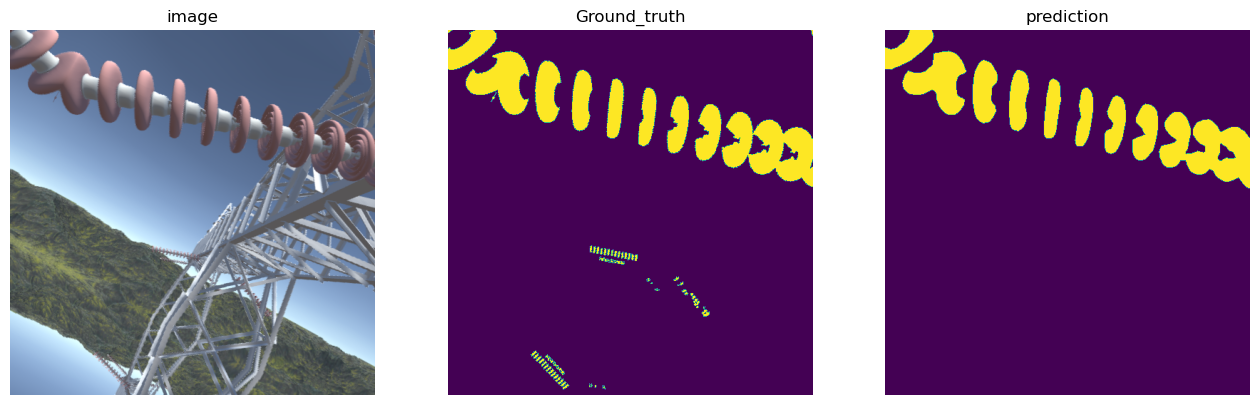

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/pspnet_resnet50_porcelain.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/pspnet_resnet50_porcelain.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_5308\3535545494.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()